# Monitoring a Multiclass Classifier Model for NLP Data with Fiddler
Unstructured data such as text are usually represented as high-dimensional vectors when processed by ML models. In this example notebook we present how [Fiddler Vector Monitoring](https://www.fiddler.ai/blog/monitoring-natural-language-processing-and-computer-vision-models-part-1) can be used to monitor NLP models using a text classification use case.

Following the steps in this notebook you can monitor different embedding models. We use the 20Newsgroups dataset and train a multi-class classifier that is applied to vector embeddings of text documents. 

After running a few pre-processing steps on the 20Newsgroups dataset (see [this notebook](https://colab.research.google.com/github/fiddler-labs/fiddler-examples/blob/main/pre-proccessing/20newsgroups_prep_vectorization.ipynb)), we create example embeddings using OpenAI and TF-IDF vectorization methods, and we train a logistic regression model to predict the text categories. Then we publish the labled data to Fiddler for monitoring. 

We monitor this model at production time and assess the performance of Fiddler's vector monitoring by manufacturing synthetc drift via sampling from specific text categories at different deployment time intervals.

---

Now we perform the following steps to demonstrate how Fiddler NLP monitoring works: 

1. Connect to Fiddler and Create a Project
2. Upload the Assets and Vectorize Text Data
3. Train a Multiclass Classifier
3. Upload Baseline Data to Fiddler
4. Add Metadata About the Model 
5. Manufacture Synthetic Data Drift and Publish Production Events
6. Get insights

## Imports

In [1]:
import pandas as pd
import numpy as np
import random
import os

# 1. Connect to Fiddler and Create a Project

First we install and import the Fiddler Python client.

In [2]:
!pip install -q fiddler-client
import fiddler as fdl
print(f"Running client version {fdl.__version__}")

Running client version 1.6.2


Before you can add information about your model with Fiddler, you'll need to connect using our API client.

---

**We need a few pieces of information to get started.**
1. The URL you're using to connect to Fiddler
2. Your organization ID
3. Your authorization token

The latter two of these can be found by pointing your browser to your Fiddler URL and navigating to the **Settings** page.

In [3]:
URL = '' # Make sure to include the full URL (including https://).
ORG_ID = ''
AUTH_TOKEN = ''

Next we run the following code block to connect to the Fiddler API.

In [4]:
client = fdl.FiddlerApi(
    url=URL,
    org_id=ORG_ID,
    auth_token=AUTH_TOKEN,
)

Once you connect, you can create a new project by specifying a unique project ID in the client's `create_project` function.

In [5]:
PROJECT_ID = 'nlp_newsgroups'

if not PROJECT_ID in client.list_projects():
    print(f'Creating project: {PROJECT_ID}')
    client.create_project(PROJECT_ID)
else:
    print(f'Project: {PROJECT_ID} already exists')

Creating project: nlp_newsgroups


# 2. Upload the Assets and Vectorize Text Data

Now we retrieve the 20Newsgroup dataset. This dataset is fetched from the [scikit-learn real-world datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#) and pre-processed using [this notebook](https://colab.research.google.com/github/fiddler-labs/fiddler-examples/blob/main/pre-proccessing/20newsgroups_prep_vectorization.ipynb).

In [ ]:
DATA_PATH = 'https://media.githubusercontent.com/media/fiddler-labs/fiddler-examples/main/quickstart/data/'
source_df = pd.read_csv(DATA_PATH + '20newsgroups_preprocessed.csv')
source_df

# Vectorization via Text Embeddings

## OpenAI Embeddings

If you have an openai account, you can use your openai key and run the following cells to get the embedding directly from openai.
However, for this example dataset we upload the openai embeddings which are previously fetched and stored by Fiddler.

In [ ]:
'''
import openai
openai.api_key = os.getenv("OPENAI_API_KEY") #Use your own OpenAI key
MODEL = "text-embedding-ada-002"
'''

In [ ]:
'''
def get_openai_embedding_batch(df, text_col_name, batch_size, model=MODEL):
    if batch_size>2000:
        raise ValueError('openai currently does not support chunks larger than 2000')
    embeddings = []
    for i in range(0, df.shape[0], batch_size):
        batch_df = df.iloc[i:i+batch_size] if i+batch_size<df.shape[0] else df.iloc[i:]
        response = openai.Embedding.create(
            input=batch_df[text_col_name].tolist(),
            model=model
        )
        response_embedding_list = [res['embedding'] for res in response['data']]
        embeddings += response_embedding_list
    embedding_col_names = ['openai_dim{}'.format(i+1) for i in range(len(embeddings[0]))]
    return pd.DataFrame(embeddings, columns=embedding_col_names)
'''

In [ ]:
'''
batch_size = 2000
text_col_name = 'original_text'
openai_df = get_openai_embedding_batch(source_df, text_col_name, batch_size, model="text-embedding-ada-002")
openai_column_names = openai_df.columns.tolist()
'''

In [10]:
openai_df = pd.read_csv(DATA_PATH + '20newsgroups_openai_embeddings.csv')
openai_column_names = openai_df.columns.tolist()

## TF-IDF Embeddings

As an alternative text embedding method, you can run the following cell to generate the TF-IDF vectors for this dataset.

In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
embedding_dimension = 300
vectorizer = TfidfVectorizer(sublinear_tf=True,
                             max_features=embedding_dimension,
                             min_df=0.01,
                             max_df=0.9,
                             stop_words='english',
                             token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

tfidf_sparse = vectorizer.fit_transform(source_df['original_text'])
embedding_cols = vectorizer.get_feature_names_out()
embedding_col_names = ['tfidf_token_{}'.format(t) for t in embedding_cols]
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf_sparse, columns=embedding_col_names)
tfidf_column_names = tfidf_df.columns.tolist()
'''

# 3. Train a Multiclass Classifier and Prepare Baseline and Production DataFrames

Now we train a classifier to predict the labels assigned to each data sample. We use the logistic regression classifier from scikit-learn for this task. We split the data into train and test subsets and we use 25% of data points to train a logistic regression model.

Here we use the first 256 components of the OpenAI embeddings as the input features to the classifier.

In [11]:
input_features = openai_column_names[0:256]
df_all = pd.concat([source_df,openai_df[input_features]], axis=1)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df_train, df_test = train_test_split(df_all, test_size=0.75, random_state=1)
clf = LogisticRegression(random_state=1).fit(df_train[input_features], df_train.target)
clf_classes = clf.classes_
prediction_col_names = ['prob_%s'%c for c in clf_classes]

Using the logistic regression classifier for a multi-class classification problem, we get a probability for each target label. We store all the predicted class probabilities as well as the predicted target for each data point in both the training and test sets.

In [13]:
predictions_train = pd.DataFrame(index=df_train.index)
predictions_train['predicted_target'] = clf.predict(df_train[input_features])
predicted_probs = clf.predict_proba(df_train[input_features])
for idx,col in enumerate(predicted_probs.T):
    predictions_train[prediction_col_names[idx]] = col

predictions_test = pd.DataFrame(index=df_test.index)
predictions_test['predicted_target'] = clf.predict(df_test[input_features])
predicted_probs = clf.predict_proba(df_test[input_features])
for idx,col in enumerate(predicted_probs.T):
    predictions_test[prediction_col_names[idx]] = col

Finally, we create the baseline and prodcution DataFrames by concatenating the corresponding predicion DataFrames to each of training and test DataFrames. The actual production events are later samples form the predicion DataFrame that we create here.

In [14]:
baseline_df = pd.concat([predictions_train, df_train], axis=1)
production_df = pd.concat([predictions_test, df_test], axis=1)

acc_baseline = sum(baseline_df['predicted_target'] == baseline_df['target'])/baseline_df.shape[0]
acc_production = sum(production_df['predicted_target'] == production_df['target'])/production_df.shape[0]

print('accuracy on baseline:{:.2f}'.format(acc_baseline))
print('accuracy on test data:{:.2f}'.format(acc_production))

accuracy on baseline:0.83
accuracy on test data:0.82


# 4. Upload Baseline Data to Fiddler

Now we create a [DatasetInfo](https://docs.fiddler.ai/reference/fdldatasetinfo) object to describe our baseline dataset.

In [15]:
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_df, max_inferred_cardinality=20)
dataset_info

,column,dtype,count(possible_values),is_nullable,value_range
0,predicted_target,CATEGORY,5,False,
1,prob_computer,FLOAT,,False,0.047 - 0.882
2,prob_forsale,FLOAT,,False,0.018 - 0.278
3,prob_recreation,FLOAT,,False,0.027 - 0.751
4,prob_religion,FLOAT,,False,0.018 - 0.731
...,...,...,...,...,...
262,openai_dim252,FLOAT,,False,-0.06 - 0.028
263,openai_dim253,FLOAT,,False,-0.05 - 0.04
264,openai_dim254,FLOAT,,False,-0.05 - 0.052
265,openai_dim255,FLOAT,,False,-0.04 - 0.036


Next we call the [upload_dataset()](https://docs.fiddler.ai/reference/clientupload_dataset) API to upload a baseline  to Fiddler. In addition to the baseline data, we also uploaded the whole production data framework as the 'test_data' dataset which allows us to look at the model performance metrics for unseen data.

In [16]:
DATASET_ID = 'newsgroups_baseline'

if not DATASET_ID in client.list_datasets(project_id=PROJECT_ID):
    print(f'Upload dataset {DATASET_ID}')
    client.upload_dataset(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    dataset={'baseline':baseline_df,
             'test_data':production_df
            },
    info=dataset_info
)
else:
    print(f'Dataset: {DATASET_ID} already exists in Project: {PROJECT_ID}.\n'
               'The new dataset is not uploaded. (please use a different name.)') 

Upload dataset newsgroups_baseline


# 5. Add Metadata About the Model

Next we should tell Fiddler a bit more about our model by creating a [model_info](https://docs.fiddler.ai/reference/fdlmodelinfo) object that specifies the model's task, inputs, outputs, and other information such as the custom features and the targets for a multi-class classification model.

While Fiddler monitores all the numerical inputs by defualt, users can define custom features by grouping a set of input features that need to be monitored as a vector (e.g., grouping the columns of the baseline DataFrame that constitute an embedding vector). Let's first show how custom features can be used to monitor vector features such as NLP embeddings.

### Define Custom Features for Vector Monitoring

In addition to univariate numerical features which Fiddler monitors by default, users can define custom features and ask Fiddler to monitor them. A custom feature is specified by a group of dataset columns that need to be monitored together a a vector.

Before creating a model info object, we define a custom feature using the [CustomFeature.from_columns()](https://docs.fiddler.ai/reference/fdlcustomfeaturefrom_columns) API. When creating a custom feature, a name must be assigned to the custom feature using the `custom_name` argument. Each custom feature appears in the monitoring tab in Fiddler UI with this assigned name. Finally, the default clustering setup can be modified by passing the number of cluster centroids to the `n_clusters` argument.

Here we define a custom feature that is a vector whose elements are stored in columns that are the dimensions of the OpenAI embeddings.

In [17]:
CF1 = fdl.CustomFeature.from_columns(input_features,
                                     n_clusters=6, 
                                     custom_name='openai_embeddings')

### Generate ModelInfo Object and Add Model 

Since this notebook demonstrates a monitoring-only use case and model predictions are already added to both baseline and production data, there is no need to access the model directly or to build a surrogate model and we use the [add_model()](https://docs.fiddler.ai/reference/clientadd_model) API. This requires passing a [model_info](https://docs.fiddler.ai/reference/fdlmodelinfo) object which conitains information about our model's task, inputs, outputs, targets and custom features that we would like to be monitored.

In [19]:
model_task = fdl.ModelTask.MULTICLASS_CLASSIFICATION
model_target = 'target'
model_outputs = prediction_col_names
model_features = input_features

model_info = fdl.ModelInfo.from_dataset_info(
    dataset_info=dataset_info,
    dataset_id=DATASET_ID,
    features=model_features,
    target=model_target,
    outputs=model_outputs,
    custom_features = [CF1],
    model_task=model_task,
    decision_cols=['predicted_target'],
    categorical_target_class_details=clf.classes_,
    metadata_cols=['original_text'],
    description='A multi-class calssifier trained on NLP embeddings.'
)
model_info

,column,dtype,count(possible_values),is_nullable,value_range
0,target,CATEGORY,5,False,
,column,dtype,count(possible_values),is_nullable,value_range
0,openai_dim1,FLOAT,,False,-0.07 - 0.038
1,openai_dim2,FLOAT,,False,-0.05 - 0.038
2,openai_dim3,FLOAT,,False,-0.05 - 0.056
3,openai_dim4,FLOAT,,False,-0.06 - 0.027
4,openai_dim5,FLOAT,,False,-0.07 - 0.04
...,...,...,...,...,...
251,openai_dim252,FLOAT,,False,-0.06 - 0.028
252,openai_dim253,FLOAT,,False,-0.05 - 0.04


In [35]:
with open('model.yaml', 'w') as yaml_file:
    yaml.dump({'model': model_info.to_dict()}, yaml_file)

In [20]:
MODEL_ID = 'log_regression'

if not MODEL_ID in client.list_models(project_id=PROJECT_ID):
    client.add_model(
        project_id=PROJECT_ID,
        dataset_id=DATASET_ID,
        model_id=MODEL_ID,
        model_info=model_info
    )
else:
    print(f'Model: {MODEL_ID} already exists in Project: {PROJECT_ID}. Please use a different name.')

# 6. Manufacture Synthetic Data Drift and Publish Production Events

Now we publish some production events into Fiddler. We publish events in data batches and manually create data drift by sampling from particular newsgroups. This allows us to evaluate the effectiveness of Fiddler vector monitoring.

In [21]:
batch_size = 900 #number of events per (daily) bin
event_batches_df=[]

For sanity check, we use the baseline data as the first event batch

In [22]:
event_batches_df.append(baseline_df)

Next sample from all categories (same as baseline)

In [23]:
n_intervals = 6
for i in range(n_intervals):
    event_batches_df.append(production_df.sample(batch_size))

Now we generate synthetic data drift by adding event batches that are sampled from specific newsgroups

In [24]:
T1 = ['computer','science','recreation']
T2 = ['science','religion']
T3 = ['religion']
T4 = ['computer','science','religion','forsale']
T5 = ['science','religion','forsale']
T6 = ['forsale']
synthetic_intervals = [T1,
                       T2,
                       T3,T3,T3,T3,
                       T4,T4,T4,
                       T5,T5,
                       T6,
                       ]

In [25]:
for categories in synthetic_intervals:
    production_df_subset = production_df[production_df['target'].isin(categories)]
    event_batches_df.append(production_df_subset.sample(batch_size, replace=True))

Add more intervals sampled from all categories (no data drift)

In [26]:
n_intervals = 6
for i in range(n_intervals):
    event_batches_df.append(production_df.sample(batch_size))

### Add Timestamp to Batches and Publish Events

In [27]:
from datetime import datetime, date, time 
today_beginning = datetime.combine(date.today(), time()).timestamp()
daily_time_gap = 24*3600 #daily time gap in seconds

In [28]:
#start from 29 days back
timestamp= today_beginning - 29*daily_time_gap
for event_df in event_batches_df:
    timestamp_vec = [timestamp + random.randrange(daily_time_gap) for i in range(len(event_df))]
    event_df['timestamp'] = timestamp_vec
    timestamp += daily_time_gap

Publish events

In [29]:
for event_df in event_batches_df:
    client.publish_events_batch(
        project_id=PROJECT_ID,
        model_id=MODEL_ID,
        batch_source=event_df,
        timestamp_field= 'timestamp' #comment this line if you are not adding timestamps
    )

# 7. Get insights


**You're all done!**
  
You can now head to Fiddler URL and start getting enhanced observability into your model's performance. Run the following code block to get your URL:



In [30]:
print('/'.join([URL, 'projects', PROJECT_ID, 'models', MODEL_ID, 'monitor']))

https://preprod.fiddler.ai/projects/nlp_newsgroups/models/log_regression/monitor


In particular, you can go to the monitoring tab in your Fiddler URL and check the resulting drift chart for the TF-IDF embedding vectors. Bellow is a sceernshot of the data drift chart after running this notebook on the [Fiddler demo](https://demo.fiddler.ai/) deployment. (Annotation bubbles are not generated by the Fiddler UI.)

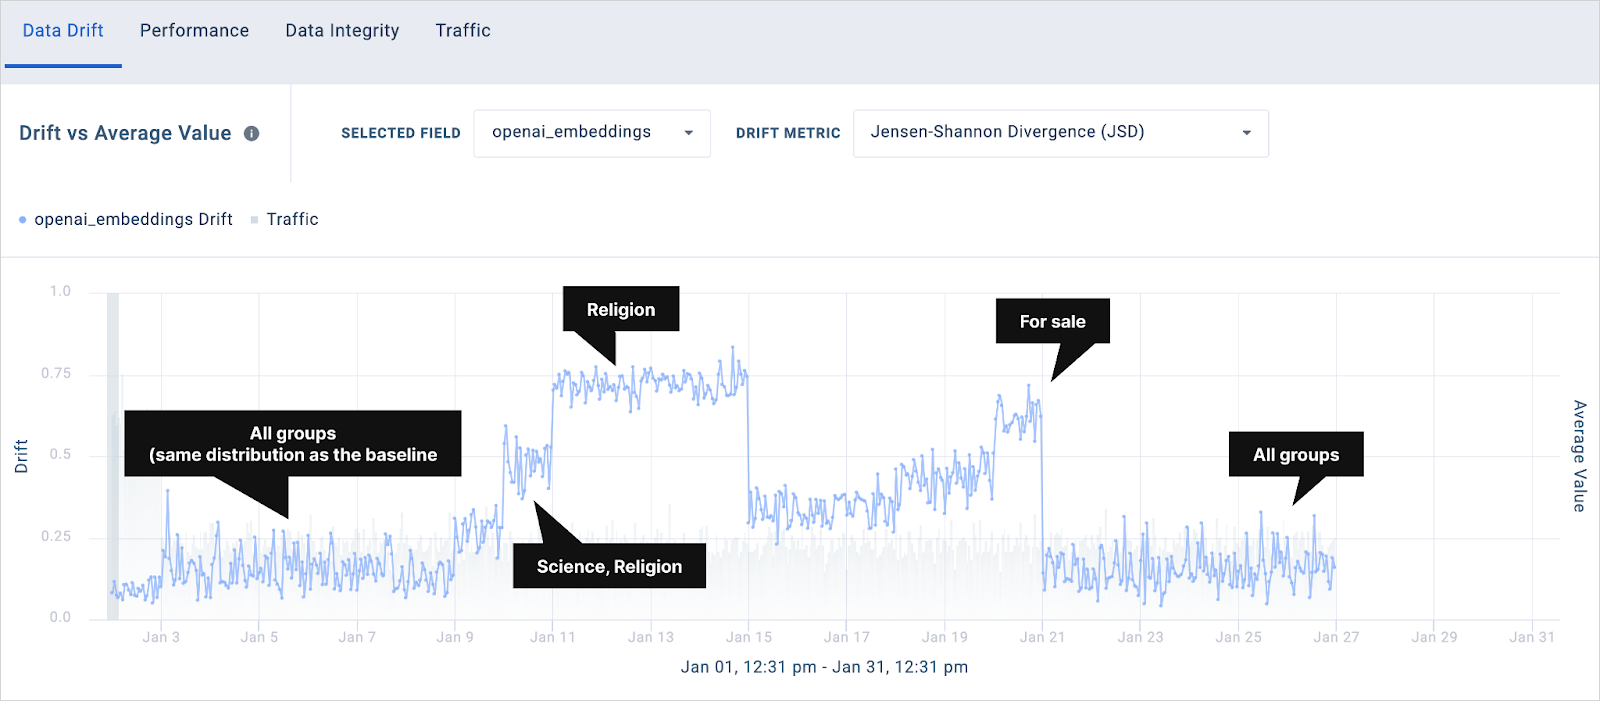

--------
**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

Join our [community Slack](http://fiddler-community.slack.com/) to ask any questions!

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.